# Swarm 으로 챗봇 만들기

## 준비

### 라이브러리 설치 및 임포트

In [100]:
!pip install git+https://github.com/openai/swarm.git
!pip install pydantic langchain langgraph

  Cloning https://github.com/openai/swarm.git to c:\users\inkyu.choi\appdata\local\temp\pip-req-build-20tym88f
  Resolved https://github.com/openai/swarm.git to commit 0c82d7d868bb8e2d380dfd2a319b5c3a1f4c0cb9
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/swarm.git 'C:\Users\inkyu.choi\AppData\Local\Temp\pip-req-build-20tym88f'


  Using cached langgraph_prebuilt-0.1.8-py3-none-any.whl.metadata (5.0 kB)
  Using cached xxhash-3.5.0-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached ormsgpack-1.9.1-cp311-cp311-win_amd64.whl.metadata (44 kB)
Using cached ormsgpack-1.9.1-cp311-cp311-win_amd64.whl (125 kB)
Using cached xxhash-3.5.0-cp311-cp311-win_amd64.whl (30 kB)
Using cached langgraph_prebuilt-0.1.8-py3-none-any.whl (25 kB)

   -------------------- ------------------- 3/6 [langgraph-checkpoint]
   --------------------------------- ------ 5/6 [langgraph]
   ---------------------------------------- 6/6 [langgraph]



In [101]:
from typing import TypedDict, List, Dict, Literal
from pydantic import BaseModel, Field
from swarm import Swarm, Agent
from langchain.output_parsers import PydanticOutputParser
from langgraph.graph import StateGraph, START, END

import random

In [2]:
# 환경 변수 및 전역 변수 관리
import os

def load_api_keys(filepath):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

filepath = '../.env'

# API 키 로드 및 환경변수 설정
load_api_keys(filepath)

ollama_model = 'qwen3:latest'
client = Swarm()

In [105]:
# 임시로 사용 할 이력서 데이터
resume = """<이력서>
홍길동 (Gil-dong Hong)
이메일: gildong.hong@example.com
전화번호: 010-1234-5678
학력
- 한국대학교 전기정보공학부 학사 (2018.03 ~ 2022.02)
 GPA: 3.91 / 4.3, 전공과목: 머신러닝, 데이터마이닝, 신호처리
경력
- KT, AI 연구소 인턴 (2021.07 ~ 2021.12)
 • OCR 기반 문서 처리 시스템 고도화
 • Tesseract + 딥러닝 후처리 파이프라인 설계
 • 사내 법률문서 정제 정확도 12% 개선
- 빅데이터 학생연합 (BDSA) 기술부장 (2020.03 ~ 2021.02)
 • Python 기반 크롤러 및 Flask API 개발
 • 공공데이터 기반 부동산 가격 예측 프로젝트 리드
프로젝트
- AI 면접관 시스템 개발 (졸업 과제)
 • OpenAI GPT + Streamlit + FAISS 기반 질문-응답 시스템 구현
 • 이력서 기반 질문 자동 생성 + 답변 피드백 제공
- 딥러닝 기반 교통량 예측 (교과목 프로젝트)
 • LSTM 기반 모델 + 서울시 교통데이터
 • MAE 15% 이하로 개선
기술 스택
- Python, PyTorch, TensorFlow, OpenCV
- MySQL, MongoDB, Git, Docker
- 영어 (TOEIC 915, 영어면접 가능)
수상 및 자격
- SKT Big Data Challenge 2021 장려상
- 정보처리기사 (2022.05 취득)
기타
- Github: github.com/gildong-ai
- 블로그: blog.naver.com/gildong_dev
<자기소개서>
1. 본인 성격의 강/약점에 대해서 실제 사례를 포함하여 작성해 주세요.
무엇인가 한번 빠져들면 해결하거나 성취할 때까지 모든 열정/노력을 쏟아붓는 성격으로, 그 과정에서 큰 어려움이 발생하더라도 포기하지 않고 가능한 방법들을 찾아 해결하는 편입니다.
특히 프로그래밍에 있어서는 공식적으로 제공되는 레퍼런스 문서를 보는것을 좋아하며, 이런 과정을 통해 새로운 지식을 습득하는 것에 보람을 느끼고 있습니다.
물론 문제가 발생하는 상황을 좋아하지 않기 때문에, 문제와 관련된 내용을 다루는 문서 아티클이 존재하지 않거나 제시된 대로 따랐을 때 문제가 해결되지 않는다면 답답함을 느끼거나 가벼운 스트레스 받는다는 것이 단점이기는 하지만,
개인적으로 좋아하는 커피를 마시거나 간단한 독서를 통해 기분 전환하여 해결하는 편이며, 주어진 문제 상황을 어떻게든 해결함으로써 문제로 인해 받았던 스트레스를 해소함과 동시에 성취감을 느끼는 것 같습니다.
해결했다는 성취감은 다시 개발에 빠져들게 되는 원동력이 되어 긍정적인 선순환이 이루어지는 것 같습니다.
개발 과정에서 알 수 없는 버그가 발생하였을 때 불가피한 경우 문제가 예상되는 부분에 Break point를 찍고 라인 단위로 프로그램을 실행해 메모리 상의 비트 단위까지 추적했던 경험도 가지고 있으며,
프로젝트 서버 배포 과정에서 로컬에서는 발생하지 않았던 문제가 발생하였을 때 에러 로그에 관련된 문서를 모두 확인하여 배포했던 경험도 가지고 있습니다.

2. 본인이 회사를 선택하는 기준을 바탕으로 우리 회사를 선택한 이유를 작성해 주세요.
회사가 안정적이고 어느 정도 큰 규모라는 것이 회사를 선택하는 데 있어 가장 중요한 부분이라고 생각합니다.
물론 규모가 작은 스타트업도 배울 점은 많고 좋은 회사들이 많이 있지만, 일반적으로 큰 규모를 가지고 오랜 기간 운영된 회사가 내부적으로 쌓아온 인프라도 존재하고 문제 상황이 발생하였을 때
도움을 구할 수 있는 주변 동료들이 많이 존재하여 회사를 선택하는 데 있어서 어느 정도 큰 규모라는 것이 중요하다 생각합니다.
또한 회사가 시장 상황을 비롯해 외부 환경적인 요소로 사이클을 타거나 불안정적인 구조를 가지고 있는 것보다는, 안정적인 내부 서비스가 존재하여 일정한 매출/수익을 거둘 수 있어 각 구성원은 아무 걱정 없이 맡은 바 소임 다해
회사에 기여하는 것 역시 개인적으로 중요하다 생각합니다.
KK기술은 안정적인 키움증권을 운영하는 규모 있는 벤처 기업으로 IT에 뿌리하고 있기 때문에 개발자 친화적이고 사내에서 동료 간의 배울 수 있는 부분이 많을 것이라 생각되며, 출퇴근 시간을 유동적으로 사용할 수 있는 유연근무제를 지원하여,
출퇴근에 무의미하게 낭비하는 시간을 줄이고 개인 개발 시간을 확보할 수 있을 것 같아 입사하고 싶은 기업입니다.
또한 교육에 대한 지원이 있어 개인적으로 크게 성장할 수 있는 환경이라 생각되며, 트리플 모니터를 사용함으로써 순수하게 개발에 집중할 수 있는 환경이라 생각되어 KK기술에 꼭 입사하고 싶습니다.

3. 해당 직무에 지원하신 이유, 본인이 적합하다고 판단하는 근거, 관련 산출물 등을 작성해 주세요. (프로젝트, 포트폴리오, github/블로그 URL 등이 있다면 간단한 설명과 함께 작성)
키움 증권을 비롯한 KK기술의 금융 계열사의 서비스 개발에 직접 참여할 수 있고, 많은 사용자가 존재하는 환경 속에서 운영해 볼 수 있다는 부분이 지원에 대한 가장 큰 동기인 것 같습니다.
OOOOO 교육과정 이전에는 이론적인 내용만 습득하였어서 실무에 대한 이해와 경험이 부족한데 사용자가 많은 환경에서 직접 개발과 운영에 참여하면 경험적인 부분이 크게 성장할 것 같습니다.
비록 그동안의 프로젝트 경험이 부족해서 직무에 대한 적합성을 직접적으로 보여드릴 수 없어 아쉽지만, 실제 실무에 대해 배워나가는 OOOOO 과정에서 코딩 집중과정 종합성적 서울 9반 1등 성적 우수상을 받고,
현재 OOOOO 내에서 진행 중인 프로젝트에서 Jira를 활용한 협업과, Jenkins를 이용한 배포를 진행하고 있어 실제 KK기술에 입사하였을 때 프로젝트를 진행하는 데 있어서 문제가 없다 자신 있게 말씀드릴 수 있습니다.
또한 알고리즘 공부를 시작한 이후에 꾸준히 약 200일간 매일 알고리즘 문제를 풀어 오고 있으며 알고리즘 학습 내용을 바탕으로 OOOO에서 주관하는 OO 상시 SW 역량 테스트에 응시하여 B형(Pro) 등급을 취득하였습니다.
개발자로써 항상 새로운 것을 배우고 적용해나가야 한다 생각하는 편이며, 언어에 대한 이해와 더 좋은 코드를 작성할 수 있도록 Effective Java를 읽고 항상 코딩하는 과정에서 생각하고 적용하려 노력하고 있으며,
현재 알고 있는 지식에 안주하지 않기 위해 현재 알고 있는 SQL Mapper(MyBatis) 외에 ORM(JPA Hibernate)를 학습하고 있고, Spring In Action을 구매하여 스프링에 대해 심도 있게 학습하려 준비하고 있습니다.

4. 본인이 지원한 직무에서 입사 후 어떠한 업무를 하고 싶은지 작성해 주세요.
무엇이든 저에게 주어진 일이라면 큰 책임감을 느끼고 할 수 있는 모든 노력을 쏟는 편이고, 개발에 있어서 대부분을 재미있어하는 편입니다.
다만 실제 사용자에게 보이고 UI/UX 작업을 하는 프론트엔드 분야에 대해서는 일이 맡겨진다면 주어진 일을 끝낼 자신은 있지만 프론트엔드에 대한 흥미는 낮아서 프론트엔드 분야를 제외한 업무를 제외한 업무를 하고 싶습니다.
스프링을 이용한 서버 프로그램 개발이나, 리눅스 서버를 이용한 서비스 배포 모두 저에겐 흥미로운 주제이며, KK기술에 입사하게 된다면 서버에 관련된 업무에 배정되고 싶습니다.
OOOOO에서 협업 특강에서 코드 리뷰에 대해 접할 수 있던 기회가 있었는데 협업에서 코드 리뷰의 중요성을 깨달을 수 있던 기회였고, 실무에서 기회가 된다면 활발하게 코드 리뷰 할 수 있는 기회도 존재하면 좋을 것 같습니다.
금융을 제외하더라도 전반적인 IT 산업에서 보안적인 요소를 고려하는 중요하지만, KK기술의 금융 직무에서는 고객의 민감정보를 다루고 무결성을 보장해야만 하기 때문에 피어리뷰의 중요도가 높다고 생각됩니다.
개인적으로 희망하고 있는 스프링 서버 개발을 진행하며, 동료들과 보안적인 관점과 효율적인 구현/알고리즘에 대한 고민을 코드 리뷰로써 활발하게 할 수 있는 부서/직무를 할 수 있다면 가장 좋은 여건이 될 것 같습니다.
"""
common_prompt = "출력 시 반드시 한국어만 사용해야 하며 한자는 포함하면 안돼."

In [4]:
def get_result(raw_message: str) -> str:
    split_message = raw_message.split('\n</think>')
    return split_message[-1].strip()

## 전처리

In [9]:
# state type 선언
class InterviewState(TypedDict):
    # 고정 정보
    resume_text: str
    resume_summary: str
    resume_keywords: List[str]
    question_strategy: Dict[str, Dict]

    # 인터뷰 로그
    current_question: str
    current_answer: str
    current_strategy: str
    conversation: List[Dict[str, str]]
    evaluation :Dict[str, str]
    evaluate_reflect_count: int
    next_step : str

    # 결과
    total_feedback: str

### 이력서 분석

In [10]:
class ResumeInfo(BaseModel):
    summary: str = Field(..., description="이력서 데이터의 중요한 부분을 요약합니다.")
    keywords: List[str] = Field(..., description="이력서 데이터의 중요한 키워드를 뽑아냅니다.")

In [68]:
def analyze_resume(state: InterviewState) -> InterviewState:
    parser = PydanticOutputParser(pydantic_object=ResumeInfo)

    interviewer_agent = Agent(
        name="Resume Analysis",
        instructions="""너는 유능한 인재를 선발하는 기업의 면접관이야.
        다음 주어지는 이력서 데이터를 이력서의 핵심 키워드와 요약본을 통해 지원자에게 질문을 할거야.
        이를 염두해서 다음과 같은 분석을 수행해줘:

        1. 핵심 키워드 추출 : 지원자의 이력서와 자기소개서에서 질문을 위한 핵심 키워드를 쉼표로 구분해서 추출해줘.
        2. 전체 이력서 요약 : 추출한 핵심 키워드를 바탕으로 지원자의 이력서와 자기소개서를 요약해줘.

        응답 예시는 아래와 같아:
        {
            "summary": "지원자는 전기전자공학을 전공하고, AI 영상처리 프로젝트와 관련된 다양한 경험을 보유하고 있다...",
            "keywords": ["딥러닝", "OpenCV", "연합동아리", "인턴십", "캡스톤디자인"],
        }
        """ + common_prompt,
        model=ollama_model,
    )

    response = client.run(
        agent=interviewer_agent,
        messages=[
            { "role": "user", "content": state["resume_text"] },
            { "role": "system", "content": parser.get_format_instructions() }
        ])

    result = get_result(response.messages[-1]['content'])
    resume_info = parser.parse(result)

    return {
        **state,
        "resume_keywords": resume_info.keywords,
        "resume_summary": resume_info.summary,
    }

### 질문전략 수립

In [12]:
class Strategy(BaseModel):
    questions: Dict[str, Dict] = Field(..., description="분야에 따른 질문 전략과 예시로 사용할 질문")

In [70]:
def generate_question_strategy(state: InterviewState) -> InterviewState:
    parser = PydanticOutputParser(pydantic_object=Strategy)

    pre_interview_questions_agent = Agent(
        name="Pre-Interview Questions Generator",
        instructions="""너는 유능한 인재를 선발하는 기업의 면접관이야.
        다음 주어지는 이력서&자기소개서 요약과 주요 키워드, 키워드 중요도를 바탕으로 면접자에게 질문을 해야 해.

        이러한 점을 주의하여 다음 3가지 분야에 대해 질문 방향과 예시 질문을 만들어줘.

        3가지 분야는 다음과 같아.
        1. 경력 및 경험
        2. 동기 및 커뮤니케이션
        3. 논리적 사고.

        응답에 대한 예시는 다음과 같아.
        {
            "경력 및 경험": {
                "질문 방향": "지원자의 전기정보 공학 배경과 관련된 실무 경험을 파악하고, 그에 따른 직무 적합성을 평가 할 수 있는 질문들.",
                "예시 질문": [
                    "전기정보공학을 전공하며 습득한 지식이 머신러닝 및 데이터 마이닝 프로젝트에 어떻게 활용되었는지 구체적으로 설명해 주실 수 있나요?",
                    "빅데이터 학생연합에서 기술부장으로 활동하면서 겪은 도전과 이를 통해 배운 점은 무엇인가요?"
                ]
            }
        }

        위 예시를 보고 포맷에 맞춰 응답해줘.
        """ + common_prompt,
        model=ollama_model,
    )

    response = client.run(
        agent=pre_interview_questions_agent,
        messages=[{ "role": "user", "content": f"이력서 요약: {state['resume_summary']}, 이력서 키워드: {state['resume_keywords']}" },
                  { "role": "system", "content": parser.get_format_instructions() }
                  ])

    result = get_result(response.messages[-1]['content'])
    strategy = parser.parse(result)

    return {
        **state,
        "question_strategy": strategy.questions,
    }


### 전처리 코드 병합

In [14]:
def select_random_question_with_category(question_strategy: Dict[str, Dict]):
    all_example_questions=[]

    for category, strategy in question_strategy.items():
        questions = strategy.get("예시 질문", [])
        for question in questions:
            all_example_questions.append((category, question))  # (카테고리, 질문)

    return random.choice(all_example_questions) if all_example_questions else (None, None)

def pre_processing_interview(resume_text: str) -> InterviewState:
    state: InterviewState = {
        "resume_text": resume_text,
        "resume_summary": "",
        "resume_keywords": [],
        "question_strategy": {},

        "current_question": "",
        "current_answer": "",
        "current_strategy": "",
        "conversation": [],
        "evaluation": {},
        "evaluate_reflect_count": 0,
        "next_step": "",

        "total_feedback": "",
    }

    state = analyze_resume(state)
    state = generate_question_strategy(state)

    current_strategy, selected_question = select_random_question_with_category(state['question_strategy'])

    # return 코드는 제공합니다.
    return {
        **state,
        "current_question": selected_question,
        "current_strategy": current_strategy,
    }

## 고도화

### 답변 입력

In [16]:
def update_current_answer(state: InterviewState, user_answer: str) -> InterviewState:
    return {
        **state,
        "current_answer": user_answer.strip()
    }

### 평가

In [32]:
class Evaluation(BaseModel):
    content: Dict[str, str] = Field(..., description="다음과 같은 속성이 구성 되어있음. '분야', '질문', '답변', '질문과의 관련성', '답변의 구체성', '평가종합', '평가에 대한 이유'")

In [71]:
def evaluate_answer(state: InterviewState) -> InterviewState:
    parser = PydanticOutputParser(pydantic_object=Evaluation)

    interviewer_agent = Agent(
        name="Interviewer",
        instructions="""너는 기업의 면접관이야.
        다음 주어지는 질문과 질문에대한 관련 분야와 그에 대한 답변에 평가를 해줘.

        평가의 기준은 다음과 같아.
        1. 질문과의 관련성
            상: 질문의 핵심 의도에 정확히 부합하며, 전반적인 내용을 명확히 다룸.
            중: 질문과 관련은 있지만 핵심 포인트가 부분적으로 누락됨.
            하: 질문과 관련이 약하거나 엉뚱한 내용중심.
        2. 답변의 구체성
            상: 질문에 대한 답변이 대부분 구체적으로 다루어짐.
            중: 질문에 대한 답변이 일부 구체적이나 핵심적인 구체성이 떨어짐.
            하: 질문에 대한 답변이 대부분 구체적이지 못함.

        응답에 대한 예시는 다음과 같아.
        {
            "분야": "경력 및 경험",
            "질문": "전기정보공학을 전공하며 습득한 지식이 머신러닝 및 데이터 마이닝 프로젝트에 어떻게 활용되었는지 구체적으로 설명해 주실 수 있나요?",
            "답변": "잘 모르겠습니다",
            "질문과의 관련성": "하",
            "답변의 구체성": "하",
            "평가종합": "하",
            "평가에 대한 이유": "지원자의 답변은 질문의 핵심 의도인 전공 지식의 실무 적용 사례와 전혀 연결되지 않았으며, 내용 또한 단편적이고 구체적인 예시나 설명이 부족해 질문에 대한 명확한 이해와 준비가 부족한 것으로 판단됨."
        }
        위 예시를 보고 포맷에 맞춰 응답해줘. 특히 평가에 대한 이유 부분은 질문에 대한 답변이 어느 부분에서 어떻게 부족했는지 300자 내외로 상세히 작성해줘.
        """ + common_prompt,
        model=ollama_model,
    )

    response = client.run(
        agent=interviewer_agent,
        messages=[{ "role": "user", "content": f"분야: {state['current_strategy']}, 질문: {state['current_question']}, 답변: {state['current_answer']}" },
                  { "role": "system", "content": parser.get_format_instructions() }
                  ])

    result = get_result(response.messages[-1]['content'])
    evaluation = parser.parse(result).content

    if len(state["conversation"]) > 0:
        prev_evaluation = state["conversation"][-1]

        if evaluation["질문"] == prev_evaluation["질문"] and evaluation["답변"] == prev_evaluation["답변"]:
            state["conversation"].pop()
            state['evaluate_reflect_count'] += 1
        else:
            state['evaluate_reflect_count'] = 0

    state["conversation"].append(evaluation)

    return {
        **state,
        "evaluation": evaluation
    }


In [51]:
class Reflect(BaseModel):
    result: str = Field(..., description="'정상' 혹은 '재평가 필요'")
    reason: str = Field(..., description="평가 검증에 대한 이유.")

In [72]:
def reflect_evaluation(state: InterviewState, verbose = False) -> Literal["decide_next_step", "evaluate_answer"]:
    if state['evaluate_reflect_count'] > 2:
        state['evaluate_reflect_count'] = 0
        return "decide_next_step"

    parser = PydanticOutputParser(pydantic_object=Reflect)

    evaluation_verification_agent = Agent(
        name="Evaluation Verification",
        instructions="""너는 기업 면접의 평가 보조 시스템이야.
        다음은 면접 질문, 지원자의 답변, 그리고 그것에 대한 평가와 평가에 대한 이유야.

        이 평가가 적절한지 판단해줘. 만약 평가가 적절하지 않다면 '재평가 필요'를 반환하고, 적절하면 '정상'을 반환해.
        그리고 반환한 결과에 대해 이유를 납득할 수 있게 작성해줘.

        판단 기준:
        - 평가가 질문과 답변의 내용을 제대로 반영했는가?
        - 평가가 너무 과하거나 부족하지 않은가?

        출력에 대한 포맷 예시:
        {
            result: "정상",
            reason: "질문과 답변, 평가를 고려하였을 때 적절한 평가라고 판단됨."
        }
        """ + common_prompt,
        model=ollama_model,
    )

    evaluation = state["evaluation"]

    response = client.run(
        agent=evaluation_verification_agent,
        messages=[{ "role": "user", "content": f"질문: {state['current_question']}\n답변: {state['current_answer']}\n평가: {evaluation['평가종합']}\n평가이유: {evaluation['평가에 대한 이유']}" },
                  { "role": "system", "content": parser.get_format_instructions() }
                  ])

    result = get_result(response.messages[-1]['content'])
    reflect = parser.parse(result)

    if verbose:
        print('result:', reflect.result)
        print('reflect reason:', reflect.reason)

    return "decide_next_step" if reflect.result == "정상" else "evaluate_answer"

### 인터뷰 진행 검토

In [54]:
def decide_next_step(state: InterviewState) -> InterviewState:
    next_step = state["next_step"]

    if len(state["conversation"]) >= 5:
        next_step = "end"
    else:
        last_eval = state["conversation"][-1] if state["conversation"] else {}

        relevance = last_eval.get("질문과의 관련성", "하")
        specificity = last_eval.get("답변의 구체성", "하")

        if relevance in ["중", "상"] and specificity in ["중", "상"]:
            next_step = "next_strategy"
        else:
            next_step = "additional_question"

    return {
        **state,
        "next_step": next_step
    }


### 질문 생성

In [63]:
class Question(BaseModel):
    strategy: str = Field(..., description="질문에 대한 분야. '경력 및 경험', '동기 및 커뮤니케이션', '논리적 사고' 중 하나.")
    content: str = Field(..., description="새로 생성 된 질문.")

In [85]:
def generate_question(state: InterviewState) -> InterviewState:
    next_step = state['next_step']
    current_strategy = state['current_strategy']

    question_strategy = '\n'.join([
        f"""
        {x}:
            - 질문 방향: {state['question_strategy'][x]['질문 방향']}
            - 예시 질문: {", ".join(state['question_strategy'][x]['예시 질문'])}
        """
        for x in ['경력 및 경험', '동기 및 커뮤니케이션', '논리적 사고']
    ])

    conversation = '\n\n'.join([
        f"""분야: {x['분야']},
        질문: {x['질문']}
        답변: {x['답변']}
        질문과의 관련성: {x['질문과의 관련성']}
        답변의 구체성: {x['답변의 구체성']},
        평가종합: {x['평가종합']},
        평가에 대한 이유: {x['평가에 대한 이유']}
        """
        for x in state["conversation"]
    ])

    strategy_covered = set(turn.get("분야") for turn in state["conversation"])
    all_strategies = {"경력 및 경험", "동기 및 커뮤니케이션", "논리적 사고"}

    prompt_text = ""

    if next_step == "next_strategy":
        prompt_text = f"""지원자의 '{strategy_covered ^ all_strategies if all_strategies ^ all_strategies else all_strategies}' 분야에 대한 새로운 질문을 생성해줘.
        이때 '{state['resume_keywords']}' 중 해당 분야와 관련이 있는 키워드가 있다면 해당 키워드를 활용해 질문이 만들어줘.
        이전 질문과 중복되지 않으면서 지원자의 역량을 효과적으로 평가할 수 있는 질문이어야 해.
        유사 질문 예시는 그대로 쓰지 말고, 참고만 해서 새로운 질문을 만들어줘."""
    else:
        prompt_text = f"""지원자의 가장 최근 답변 '{state['current_answer']}'에 대한 동일한 분야인 '{current_strategy}' 새로운 질문을 생성해줘.
        지원자가 언급한 내용에 대해 더 깊이 있는 설명이나 구체적인 사례를 요구하는 질문이어야 해.
        지원자의 이전 질문에 대한 평가가 좋지 못하다면, 같은 주제를 다른 각도에서 접근하는 질문을 생성해줘."""

    question_create_agent = Agent(
        name="Evaluation Verification",
        instructions=f"""다음 주어지는 면접자의 이력서 요약, 키워드, 질문전략, 이전 질문과 답변, 평가를 기반으로 {prompt_text}

        출력 예시 포맷:
        {{
            strategy: "경력 및 경험",
            content: "딥러닝 모델을 활용한 프로젝트에서 데이터 전처리 과정에서 발생한 문제를 어떻게 분석하고 해결하였는지 설명해 주실 수 있나요?"
        }}

        {common_prompt}""",
        model=ollama_model,
    )

    parser = PydanticOutputParser(pydantic_object=Question)

    response = client.run(
        agent=question_create_agent,
        messages=[{ "role": "user",
                    "content": f"""이력서 요약: {state['resume_summary']},
                                키워드: {state['resume_keywords']},
                                질문전략: {question_strategy},
                                이전 질문과 평가: {conversation}""" },
                { "role": "system", "content": parser.get_format_instructions() }])

    result = get_result(response.messages[-1]['content'])
    question = parser.parse(result)

    return {
        **state,
        "current_question": question.content.strip(),
        "current_strategy": question.strategy.strip(),
        "current_answer": ""
    }


### 피드백 보고서

In [87]:
class FeedbackInfo(BaseModel):
    feedback: str = Field(..., description="면접 질문과 답변에 대한 3~5줄의 평가 피드백")

In [95]:
def generate_feedback_paragraph(question: str, answer: str, eval_result: str, eval_reason: str) -> str:
    parser = PydanticOutputParser(pydantic_object=FeedbackInfo)

    feedback_agent = Agent(
        name="Feedback",
        instructions="""너는 AI 면접관이야.
        질문과 답변, 그리고 다른 면접관이 판단한 종합 평가 결과를 보고, 평가자의 입장에서 3~5줄로 된 구체적인 평가 피드백을 작성해줘.
        답변의 논리성, 구체성, 경험에 기반한 설명, 개선할 부분 등을 모두 고려해줘.
        """ + common_prompt,
        model=ollama_model,
    )

    response = client.run(
        agent=feedback_agent,
        messages=[{ "role": "user", "content": f"질문: {question}\n답변: {answer}\n평가: {eval_result}\n평가이유: {eval_reason}" },
                  { "role": "system", "content": parser.get_format_instructions() }
                  ])

    result = get_result(response.messages[-1]['content'])
    feedback = parser.parse(result)

    return feedback.feedback

In [89]:
class TotalFeedbackInfo(BaseModel):
    feedback: str = Field(..., description="면접 질문과 답변, 피드백에 대한 3~5줄의 종합 평가 피드백")

In [113]:
def summarize_interview(state: InterviewState) -> InterviewState:
    print('\n[summary]')
    print("-" * 100)

    for evaluate in state["conversation"]:
        question = evaluate.get("질문", "")
        answer = evaluate.get("답변", "")
        eval_result = evaluate.get("평가종합", "")
        eval_reason = evaluate.get("평가에 대한 이유", "")

        feedback = generate_feedback_paragraph(question, answer, eval_result, eval_reason)
        evaluate["상세피드백"] = feedback

        print(f"질문: {question}")
        print(f"답변: {answer}")
        print(f"질문과의 관련성: {evaluate['질문과의 관련성']}, 답변의 구체성: {evaluate['답변의 구체성']}, 종합 평가: {evaluate['평가종합']}")
        print(f"평가 이유: {eval_reason}")
        print(f"피드백:\n{feedback}")
        print("-" * 100)

    parser = PydanticOutputParser(pydantic_object=TotalFeedbackInfo)

    total_feedback_agent = Agent(
        name="Feedback",
        instructions="""너는 AI 면접관이야. 질문, 답변에 대한 피드백을 보고, 평가자의 입장에서 3~5줄로 된 구체적인 종합 평가 피드백을 작성해줘.
        답변의 논리성, 구체성, 경험에 기반한 설명, 개선할 부분 등을 모두 고려해줘.
        """ + common_prompt,
        model=ollama_model,
    )

    feedback_results = '\n'.join(
        [f'질문: {evaluate["질문"]}\n답변: {evaluate["답변"]}\n피드백: {evaluate["상세피드백"]}'
         for evaluate in state['conversation']]
    )

    response = client.run(
        agent=total_feedback_agent,
        messages=[{ "role": "user", "content": feedback_results },
                  { "role": "system", "content": parser.get_format_instructions() }
                  ])

    result = get_result(response.messages[-1]['content'])
    total_feedback = parser.parse(result)
    print(f"종합 피드백: {total_feedback.feedback}")

    return {
        **state,
        "total_feedback": total_feedback.feedback,
    }

## Agent 생성

In [114]:
# 분기 판단 함수
def route_next(state: InterviewState) -> Literal["generate", "summarize"]:
    if state['next_step'] == "end":
        return "summarize"
    else:
        return "generate"


# 그래프 정의 시작
builder = StateGraph(InterviewState)

# 노드 추가
builder.add_node('evaluate_answer', evaluate_answer)
builder.add_node('decide_next_step', decide_next_step)
builder.add_node('generate', generate_question)
builder.add_node('summarize', summarize_interview)

# 노드 연결
builder.add_edge(START, 'evaluate_answer')
builder.add_conditional_edges('evaluate_answer', reflect_evaluation)
builder.add_conditional_edges('decide_next_step', route_next)
builder.add_edge('generate', END)
builder.add_edge('summarize', END)

# 컴파일
graph = builder.compile()

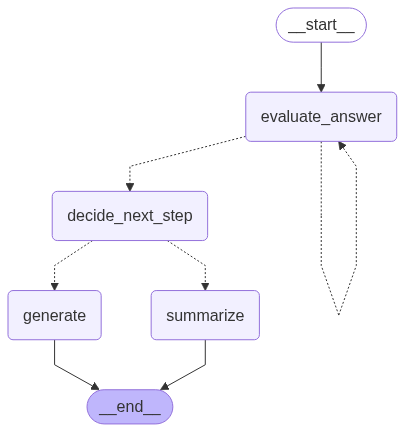

In [103]:
## 그래프 생성기
from IPython.display import Image, display

# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print(graph.get_graph().draw_mermaid())
    print('https://mermaid.live 에 복붙')
    pass

## 종합 테스트

In [110]:
state = pre_processing_interview(resume)

# 사용자 응답 루프
while True:
    message = f"""
    [질문]
    {state["current_question"]}

    [답변 입력]
    """

    state["current_answer"] = input(message)

    # 그래프 실행: 평가 → 판단 → 다음 질문 생성 or 종료
    state = graph.invoke(state)

    if state["next_step"] == "end":
        break


[summary]
----------------------------------------------------------------------------------------------------
질문: GPT 기반 시스템 도입 시 비전문가와의 기술적 협의 과정에서 어떤 전략으로 이해관계를 조율했는지 예시를 들어 설명해 주세요.
답변: Streamlit을 활용한 시연용 데모를 제작해 비전문가가 직접 사용해보며 이해할 수 있게 유도하고, 주요 개념은 시각 자료로 설명해 기능성과 필요성에 대한 공감대를 이끌어냈습니다.
피드백:
Streamlit을 활용한 시연 및 시각 자료를 통한 설명이라는 구체적인 전략 제시로 질문 의도에 대한 이해가 명확했습니다. 비전문가와의 소통에 효과적인 접근법을 실제 사례로 보여준 점 commendable합니다. 다만, 협의 중 발생한 구체적 갈등 사례나 조율 결과에 대한 설명이 부족해, 전략의 성과나 한계까지 다각도로 파악하기 어려웠습니다. 향후에는 실제 상황에서의 도전과 해결 과정을 더 구체적으로 공유하는 것이 좋겠습니다.
----------------------------------------------------------------------------------------------------
질문: 금융 IT 분야에서 안정적인 서비스 운영을 중시하는 근거를 설명해 주시고, 이에 기반한 기술적 접근 방식을 비즈니스 가치로 전환할 때 어떤 의사소통 전략을 사용했는지 구체적으로 설명해 주시기 바랍니다.
답변: 금융 IT는 거래 중단이 곧 신뢰 하락으로 직결되므로 무중단 배포, 이중화, 장애 대응 자동화 등을 도입했고, 이 과정에서 기술 용어 대신 서비스 중단 시 손실 규모 등 비즈니스 언어로 설명해 경영진의 공감을 유도했습니다.
피드백:
답변은 기술적 접근 방안과 비즈니스 가치 전환 전략을 구체적으로 설명하며, 질문의 두 축을 모두 충실히 담았습니다. 무중단 배포 등 기술적 대응 방안과 비즈니스 언어 전환 사례는 전문성과 실무 